In [51]:
import re
import numpy as np
import requests
import json
import pandas as pd
import scipy as sc
import sklearn
from sklearn import svm
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler, Normalizer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
import sys
### Gensim is outside the anaconda distribution ###
### uncomment to install Gensim ###
# !{sys.executable} -m pip install gensim
import gensim
import gensim.downloader as model_api
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [18]:
list(['us', 'gb', 'ca', 'au', 'ie', 'nz'])
COUNTRY_CODES = ['us', 'gb', 'ca', 'au', 'ie', 'nz']
APP_IDS = ['553834731', '547702041', '284882215', '333903271']
data_d = {
    'COUNTRY_CODE' : [], 
    'APP_ID' : [],
    'APP_VERSION' :[],
    'APP_RATING' : [],
    'TITLE' : [],
    'REVIEWS':[]
}

for COUNTRY_CODE in COUNTRY_CODES:
    for APP_ID_HERE in APP_IDS:
        for PAGE_NUMBER in range(1,10):
            id_num = COUNTRY_CODE+ '_' + APP_ID_HERE + '_' + str(PAGE_NUMBER)
            url  = f'https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json'
            rq = requests.get(url)
            d = json.loads(rq.content)
            entries = d['feed']['entry']
            for i in range(len(entries)):
                data_d['COUNTRY_CODE'].append(COUNTRY_CODE)
                data_d['APP_ID'].append(APP_ID_HERE)
                data_d['APP_VERSION'].append(entries[i]['im:version']['label'])
                data_d['APP_RATING'].append(entries[i]['im:rating']['label'])
                data_d['TITLE'].append(entries[i]['title']['label'])
                data_d['REVIEWS'].append(entries[i]['content']['label'])
df = pd.DataFrame(data_d)
df['APP_RATING'] = df['APP_RATING'].astype(int)
rows_to_drop = [  501,  1009,  1124,  1485,  3322,  5397,  5929,  7360,  7450,
             7957,  8009,  8057,  9085,  9141,  9427,  9447,  9884,  9911,
            10593, 10725]
df=df.drop(rows_to_drop)


In [19]:
df

,COUNTRY_CODE,APP_ID,APP_VERSION,APP_RATING,TITLE,REVIEWS
0,us,553834731,1.197.1.1,4,App drops,The app will discontinue at various points in ...
1,us,553834731,1.197.1.1,1,The game won’t load!!,I open the game it just stays on “loading” I’v...
2,us,553834731,1.197.1.1,3,IPhone 8 plus,Hasn't worked since update..
3,us,553834731,1.197.1.1,2,Fun but frustrating,I win boosters but they don't always show up. ...
4,us,553834731,1.197.1.1,1,Frustrating!!!,Been playing for two years until it recently g...
...,...,...,...,...,...,...
10795,nz,333903271,6.1.1,4,"Not bad, but has its problems","Nice overall, but:\n1. Will reset position som..."
10796,nz,333903271,6.1,1,تويتر,اصدار سيء جداً
10797,nz,333903271,6.1,5,Tweet this,"Twitter app works a charm on 4-5s I love it, i..."
10798,nz,333903271,6.1,5,Good,Good


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10780 entries, 0 to 10799
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   COUNTRY_CODE  10780 non-null  object
 1   APP_ID        10780 non-null  object
 2   APP_VERSION   10780 non-null  object
 3   APP_RATING    10780 non-null  int32 
 4   TITLE         10780 non-null  object
 5   REVIEWS       10780 non-null  object
dtypes: int32(1), object(5)
memory usage: 547.4+ KB


In [21]:
#1.1 Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy
#of the cluster overlap against the real review scores.

vectorizers = {'Count Vectorizer' : CountVectorizer(),
               'TfIdf Vectorizer' : TfidfVectorizer()}

for k, v in vectorizers.items():
    X = v.fit_transform(df['REVIEWS'])
    scaler = MaxAbsScaler()
    X_scaled = scaler.fit_transform(X)

    C_SIZE = 400
    Xd = X_scaled.toarray()
    Xd = PCA(C_SIZE).fit(Xd.T).components_.T
    Xd = sm.add_constant(Xd)

    # OLS computed by hand for convenience
    # Ypred = X(X'X)^-1 X'Y  ----- Reference here:
    # https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf
    pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['APP_RATING'].values
    print(f"{k} | OLS R^2 for compressed size of {C_SIZE}: {r2_score(df['APP_RATING'], pred)}")


Count Vectorizer | OLS R^2 for compressed size of 400: 0.37044102157770287
TfIdf Vectorizer | OLS R^2 for compressed size of 400: 0.4931996626916453


In [22]:
#1.2 Now use a sentence embedding using on of the gensim pre-trained word embedding models to achieve the same in clustering. 
#Get the best classification accuracy score you can on the 5-star review scale target using all unsupervised methods you want.

# Load pretrained word embeddings
word_vectors = model_api.load("glove-wiki-gigaword-50")

words = df['REVIEWS'].str.split()
words = pd.DataFrame(words.tolist())


In [23]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df['REVIEWS'].str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,623,624,625,626,627,628,629,630,631,632
0,the,app,will,discontinue,at,various,points,in,the,app,...,None,None,None,None,None,None,None,None,None,None
1,i,open,the,game,it,just,stays,on,“loading”,i’ve,...,None,None,None,None,None,None,None,None,None,None
2,hasn,t,worked,since,update,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,i,win,boosters,but,they,don,t,always,show,up,...,None,None,None,None,None,None,None,None,None,None
4,been,playing,for,two,years,until,it,recently,gets,stuck,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10775,nice,overall,but,1,will,reset,position,sometime,2,will,...,None,None,None,None,None,None,None,None,None,None
10776,اصدار,سيء,جداً,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
10777,twitter,app,works,a,charm,on,4,5s,i,love,...,None,None,None,None,None,None,None,None,None,None
10778,good,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [24]:
def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)
    
def map_vectors(row):
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)
    
emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())


In [17]:
# emb[emb.loc[:,0].apply(lambda x : type(x)==int) == True].index

Int64Index([  501,  1009,  1124,  1485,  3322,  5397,  5929,  7360,  7450,
             7957,  8009,  8057,  9085,  9141,  9427,  9447,  9884,  9911,
            10593, 10725],
           dtype='int64')

In [25]:
#Standard Scaler
scaler = StandardScaler()
emb_std_scaled = scaler.fit_transform(emb)

sgdr = SGDRegressor()
sgdr.fit(emb_std_scaled, df['APP_RATING'])
sgdr.score(emb_std_scaled, df["APP_RATING"])

0.2166242400961208

In [26]:
#min max scaler
scaler = MinMaxScaler()
emb_minmax_scaled = scaler.fit_transform(emb)

sgdr = SGDRegressor()
sgdr.fit(emb_minmax_scaled , df['APP_RATING'])
sgdr.score(emb_minmax_scaled , df["APP_RATING"])

0.11647074816401415

In [27]:
#Normalization
norms = ['l1', 'l2', 'max']
for norm in norms:  
    scaler = Normalizer(norm = norm)
    emb_norm = scaler.fit_transform(emb)
    sgdr = SGDRegressor()
    sgdr.fit(emb_norm, df['APP_RATING'])
    print(f'Norm {norm}: {sgdr.score(emb_norm, df["APP_RATING"])}')

Norm l1: 0.20887489888337663
Norm l2: 0.3400324674585913
Norm max: 0.2813229979904315


In [28]:
#Nonlinear transformation
quantile_transformer = QuantileTransformer(random_state=100)
emb_trans = quantile_transformer.fit_transform(emb)

sgdr = SGDRegressor()
sgdr.fit(emb_trans, df['APP_RATING'])
print(f'{sgdr.score(emb_trans, df["APP_RATING"])}')

0.3623779755002241


In [30]:
#1.3 Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best regression
#model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

tf = TfidfVectorizer(stop_words ='english')
X = tf.fit_transform(df['REVIEWS'])
y = df['APP_RATING']

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

Xd = X_scaled.toarray()
Xd = PCA(C_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

X_train, X_test, y_train, y_test = train_test_split(Xd, y, test_size=0.33, random_state=42)

clf = LinearRegression()
clf.fit(X_train, y_train)
print(f'Linear Regression with compressed size {C_SIZE} with training data')
y_train_predict = pd.Series(clf.predict(X_train)).apply(lambda x: round(x))
print(classification_report(y_train,y_train_predict, zero_division = 0))
print(f'Linear Regression with compressed size {C_SIZE} with training data')
y_test_predict = pd.Series(clf.predict(X_test)).apply(lambda x: round(x))
print(classification_report(y_test,y_test_predict, zero_division = 0))

Linear Regression with compressed size 400 with training data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0
           1       0.87      0.34      0.49      3997
           2       0.13      0.55      0.21       611
           3       0.11      0.38      0.17       499
           4       0.13      0.17      0.15       444
           5       0.85      0.19      0.31      1671
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.32      7222
   macro avg       0.23      0.18      0.15      7222
weighted avg       0.70      0.32      0.38      7222

Linear Regression with compressed size 400 with training data
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0
        

In [34]:
#1.4Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating 
#scale? Explain in a few paragraphs and justify with metrics.

print(
'''
Answer:

Comparison between classification and regression models metrics indicates that classification models generally predict better a
5-point rating scale. Most classification models tested seemed to often mistakenly predicta rating of 1. The decision tree classifier metrics indicates that it perfomed very well on training data. However, its predicting
power declined with testing data based on r squared and accuracy. The Linear SVC performed better on the testing data based on 
f1-score accuracy.

'''
)



Answer:

Comparison between classification and regression models metrics indicates that classification models generally predict better a
5-point rating scale. Most classification models tested seemed to often mistakenly predicta rating of 1. The decision tree classifier metrics indicates that it perfomed very well on training data. However, its predicting
power declined with testing data based on r squared and accuracy. The Linear SVC performed better on the testing data based on 
f1-score accuracy.




SGD CLassifier with compressed size 400 with training data:
              precision    recall  f1-score   support

           1       0.58      1.00      0.73      3997
           2       1.00      0.00      0.01       611
           3       1.00      0.00      0.01       499
           4       1.00      0.00      0.01       444
           5       0.91      0.16      0.28      1671

    accuracy                           0.59      7222
   macro avg       0.90      0.24      0.21      7222
weighted avg       0.75      0.59      0.47      7222

R_squared with training data :-0.39931654818727114

SGD CLassifier with compressed size 400 with testing data:
              precision    recall  f1-score   support

           1       0.58      1.00      0.73      1980
           2       0.00      0.00      0.00       321
           3       0.00      0.00      0.00       246
           4       0.00      0.00      0.00       196
           5       0.89      0.15      0.26       815

    accuracy  

Text(0.5, 1.0, 'Results for Classification with Testing Data')

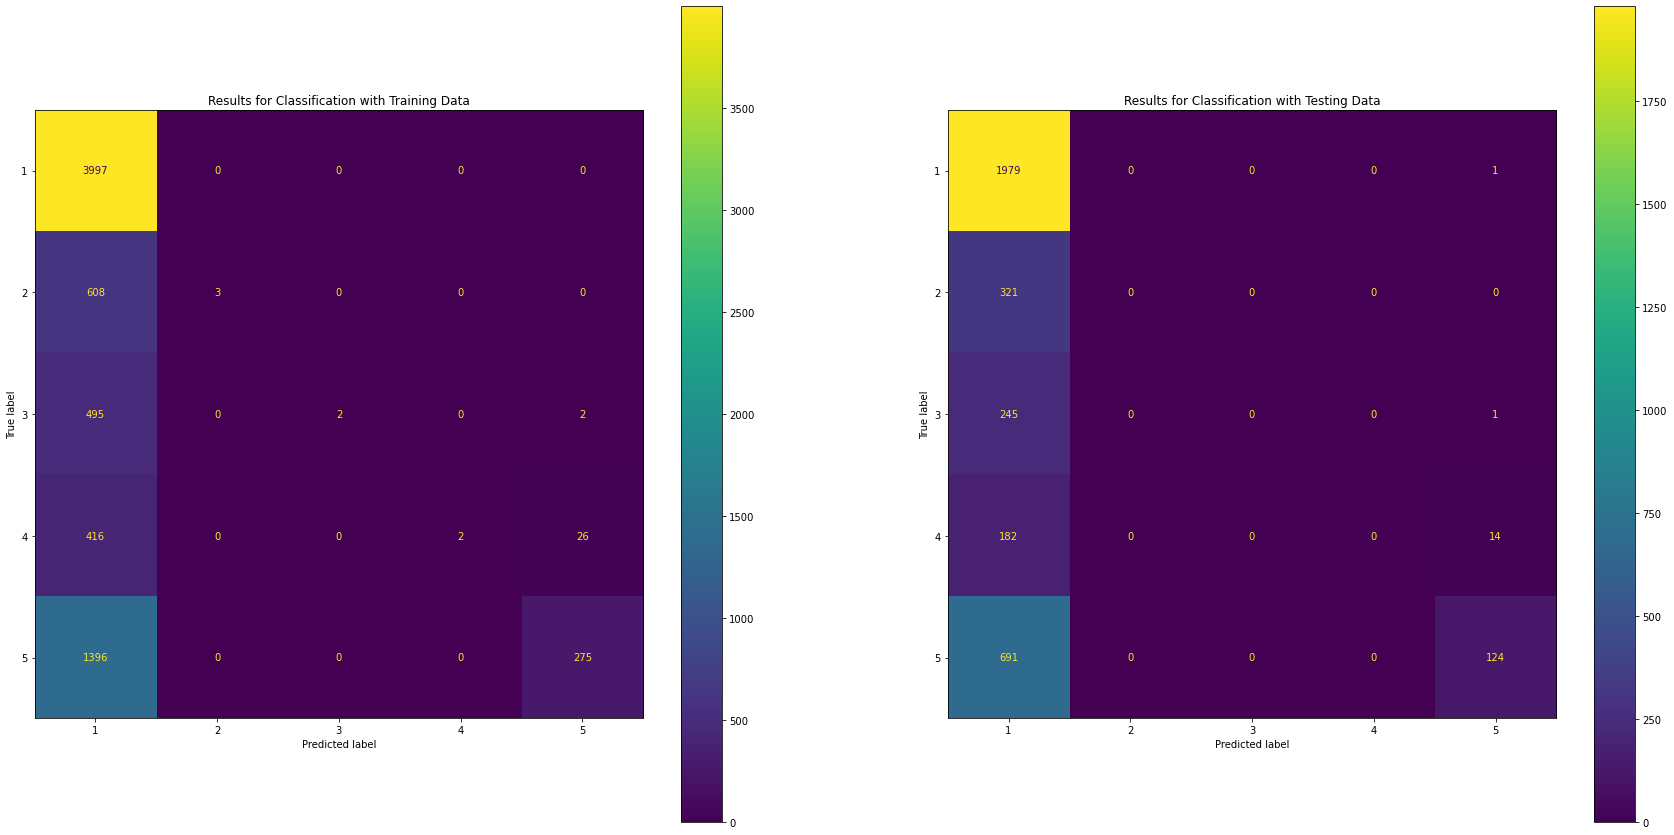

In [35]:
#1 SGD CLassifier
clf_name = 'SGD CLassifier'
clf = SGDClassifier()
clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30,15))

print(f'{clf_name} with compressed size {C_SIZE} with training data:')
print(classification_report(y_train, y_train_predict, zero_division = 0))
print(f'R_squared with training data :{r2_score(y_train,y_train_predict)}\n')
plot_confusion_matrix(clf, X_train, y_train, ax =ax1)
ax1.set_title('Results for Classification with Training Data')

print(f'{clf_name} with compressed size {C_SIZE} with testing data:')
print(classification_report(y_test,y_test_predict, zero_division = 0))
print(f'R_squared with testing data :{r2_score(y_test,y_test_predict)}')
plot_confusion_matrix(clf, X_test, y_test, ax = ax2)
ax2.set_title('Results for Classification with Testing Data')


Logistic Regression with compressed size 400 with training data:
              precision    recall  f1-score   support

           1       0.56      1.00      0.72      3997
           2       0.00      0.00      0.00       611
           3       0.00      0.00      0.00       499
           4       0.00      0.00      0.00       444
           5       0.99      0.05      0.10      1671

    accuracy                           0.57      7222
   macro avg       0.31      0.21      0.16      7222
weighted avg       0.54      0.57      0.42      7222

R_squared with training data :-0.5551807738354735

Logistic Regression with compressed size 400 with testing data:
              precision    recall  f1-score   support

           1       0.56      1.00      0.72      1980
           2       0.00      0.00      0.00       321
           3       0.00      0.00      0.00       246
           4       0.00      0.00      0.00       196
           5       0.94      0.04      0.07       815

    a

Text(0.5, 1.0, 'Results for Classification with Testing Data')

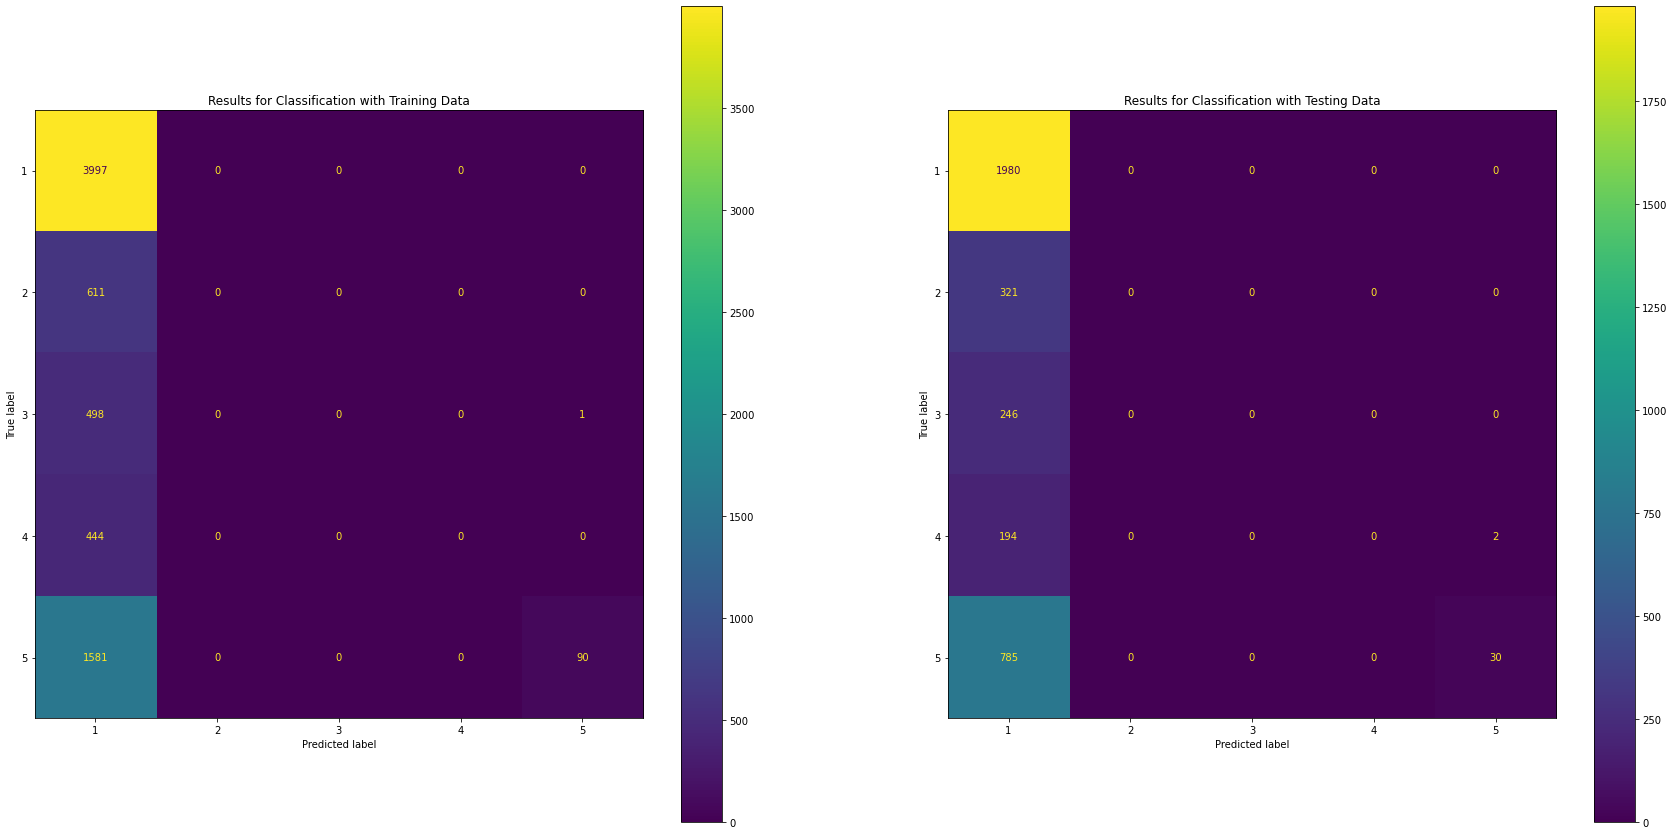

In [37]:
#2 Logistic regression
clf_name = 'Logistic Regression'
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30,15))

print(f'{clf_name} with compressed size {C_SIZE} with training data:')
print(classification_report(y_train, y_train_predict, zero_division = 0))
print(f'R_squared with training data :{r2_score(y_train,y_train_predict)}\n')
plot_confusion_matrix(clf, X_train, y_train, ax =ax1)
ax1.set_title('Results for Classification with Training Data')

print(f'{clf_name} with compressed size {C_SIZE} with testing data:')
print(classification_report(y_test,y_test_predict, zero_division = 0))
print(f'R_squared with testing data :{r2_score(y_test,y_test_predict)}')
plot_confusion_matrix(clf, X_test, y_test, ax = ax2)
ax2.set_title('Results for Classification with Testing Data')



Support Vector Machines - Linear SVC with compressed size 400 with training data:
              precision    recall  f1-score   support

           1       0.64      0.99      0.78      3997
           2       1.00      0.01      0.01       611
           3       0.67      0.00      0.01       499
           4       0.83      0.01      0.02       444
           5       0.82      0.50      0.62      1671

    accuracy                           0.67      7222
   macro avg       0.79      0.30      0.29      7222
weighted avg       0.73      0.67      0.58      7222

R_squared with training data :0.05540526370537324

Support Vector Machines - Linear SVC with compressed size 400 with testing data:
              precision    recall  f1-score   support

           1       0.64      0.99      0.78      1980
           2       0.00      0.00      0.00       321
           3       0.50      0.00      0.01       246
           4       0.00      0.00      0.00       196
           5       0.80   

Text(0.5, 1.0, 'Results for Classification with Testing Data')

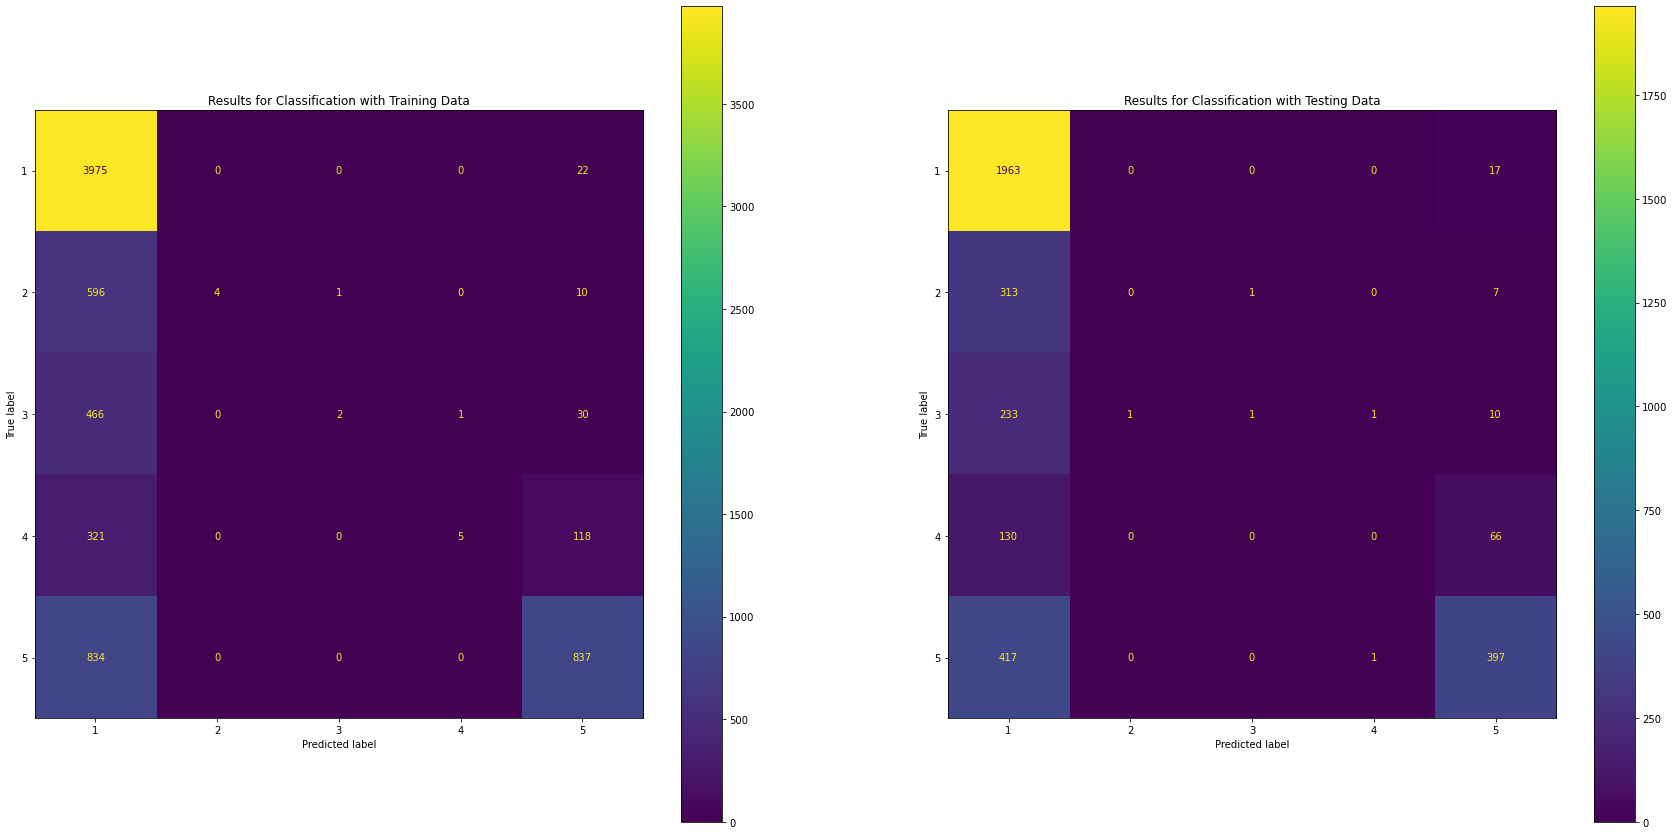

In [38]:
#3 Support Vector Machines - Linear SVC
clf_name = 'Support Vector Machines - Linear SVC'
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30,15))

print(f'{clf_name} with compressed size {C_SIZE} with training data:')
print(classification_report(y_train, y_train_predict, zero_division = 0))
print(f'R_squared with training data :{r2_score(y_train,y_train_predict)}\n')
plot_confusion_matrix(clf, X_train, y_train, ax =ax1)
ax1.set_title('Results for Classification with Training Data')

print(f'{clf_name} with compressed size {C_SIZE} with testing data:')
print(classification_report(y_test,y_test_predict, zero_division = 0))
print(f'R_squared with testing data :{r2_score(y_test,y_test_predict)}')
plot_confusion_matrix(clf, X_test, y_test, ax = ax2)
ax2.set_title('Results for Classification with Testing Data')


Support Vector Machines - NuSVC with compressed size 400 with training data:
              precision    recall  f1-score   support

           1       0.59      1.00      0.74      3997
           2       0.00      0.00      0.00       611
           3       0.00      0.00      0.00       499
           4       0.00      0.00      0.00       444
           5       0.89      0.24      0.38      1671

    accuracy                           0.61      7222
   macro avg       0.30      0.25      0.22      7222
weighted avg       0.53      0.61      0.50      7222

R_squared with training data :-0.29113302716338585

Support Vector Machines - NuSVC with compressed size 400 with testing data:
              precision    recall  f1-score   support

           1       0.59      1.00      0.74      1980
           2       0.00      0.00      0.00       321
           3       0.00      0.00      0.00       246
           4       0.00      0.00      0.00       196
           5       0.87      0.23  

Text(0.5, 1.0, 'Results for Classification with Testing Data')

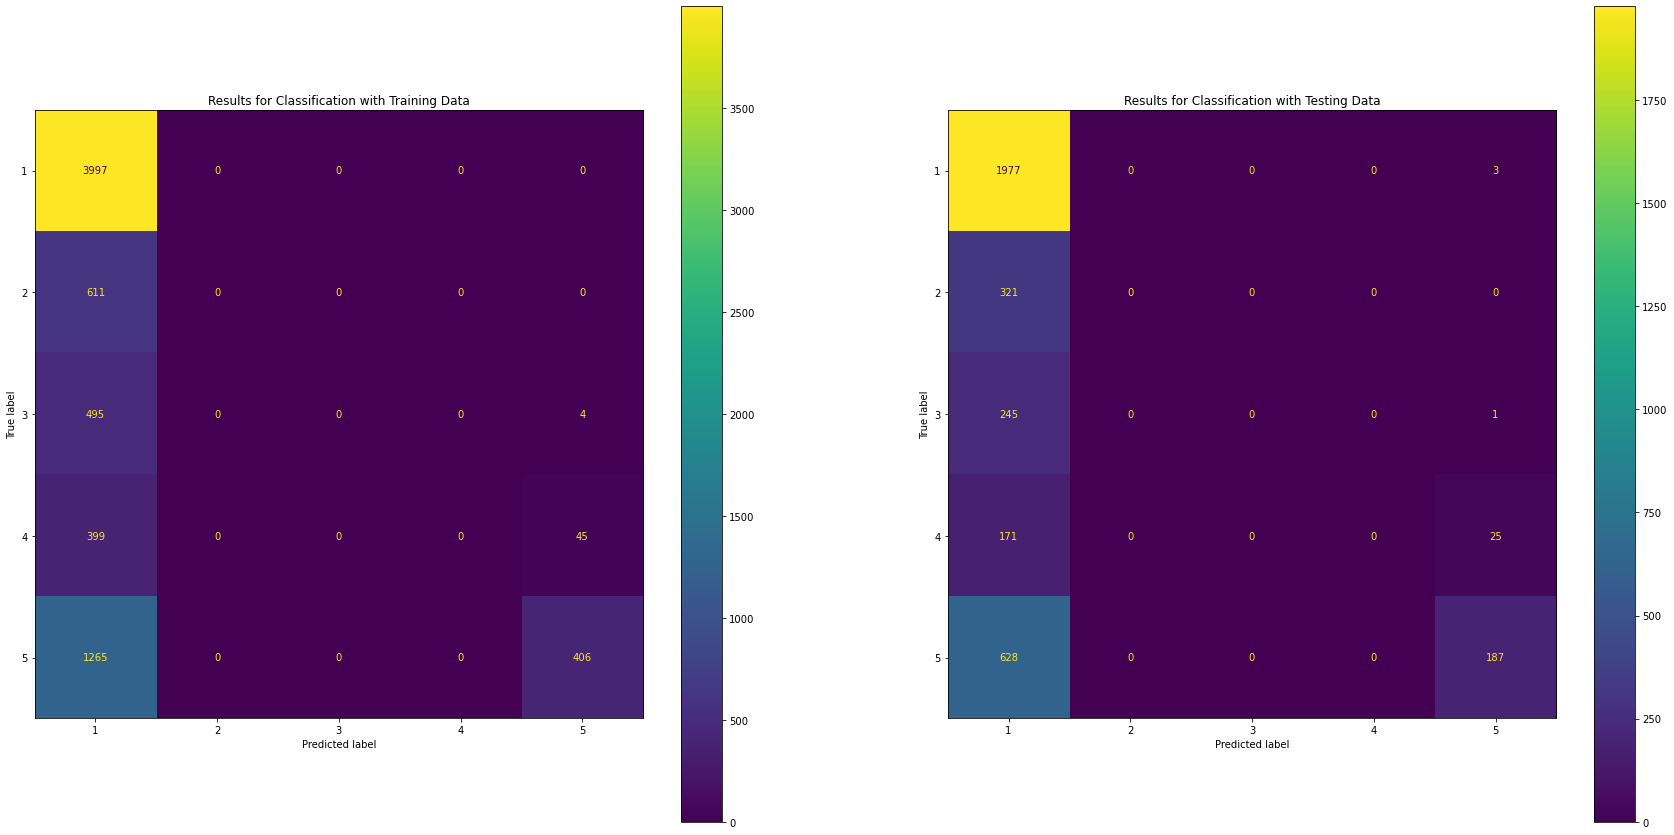

In [39]:
#4 Support Vector Machines - NuSVC
clf_name = 'Support Vector Machines - NuSVC'
clf = svm.SVC()
clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30,15))

print(f'{clf_name} with compressed size {C_SIZE} with training data:')
print(classification_report(y_train, y_train_predict, zero_division = 0))
print(f'R_squared with training data :{r2_score(y_train,y_train_predict)}\n')
plot_confusion_matrix(clf, X_train, y_train, ax =ax1)
ax1.set_title('Results for Classification with Training Data')

print(f'{clf_name} with compressed size {C_SIZE} with testing data:')
print(classification_report(y_test,y_test_predict, zero_division = 0))
print(f'R_squared with testing data :{r2_score(y_test,y_test_predict)}')
plot_confusion_matrix(clf, X_test, y_test, ax = ax2)
ax2.set_title('Results for Classification with Testing Data')


Decision Tree Classifier with compressed size 400 with training data:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      3997
           2       1.00      0.99      1.00       611
           3       1.00      0.98      0.99       499
           4       0.99      0.87      0.93       444
           5       0.95      0.99      0.97      1671

    accuracy                           0.98      7222
   macro avg       0.99      0.96      0.97      7222
weighted avg       0.98      0.98      0.98      7222

R_squared with training data :0.957194623046881

Decision Tree Classifier with compressed size 400 with testing data:
              precision    recall  f1-score   support

           1       0.70      0.66      0.68      1980
           2       0.12      0.13      0.12       321
           3       0.09      0.10      0.09       246
           4       0.07      0.07      0.07       196
           5       0.54      0.58      0.56       81

Text(0.5, 1.0, 'Results for Classification with Testing Data')

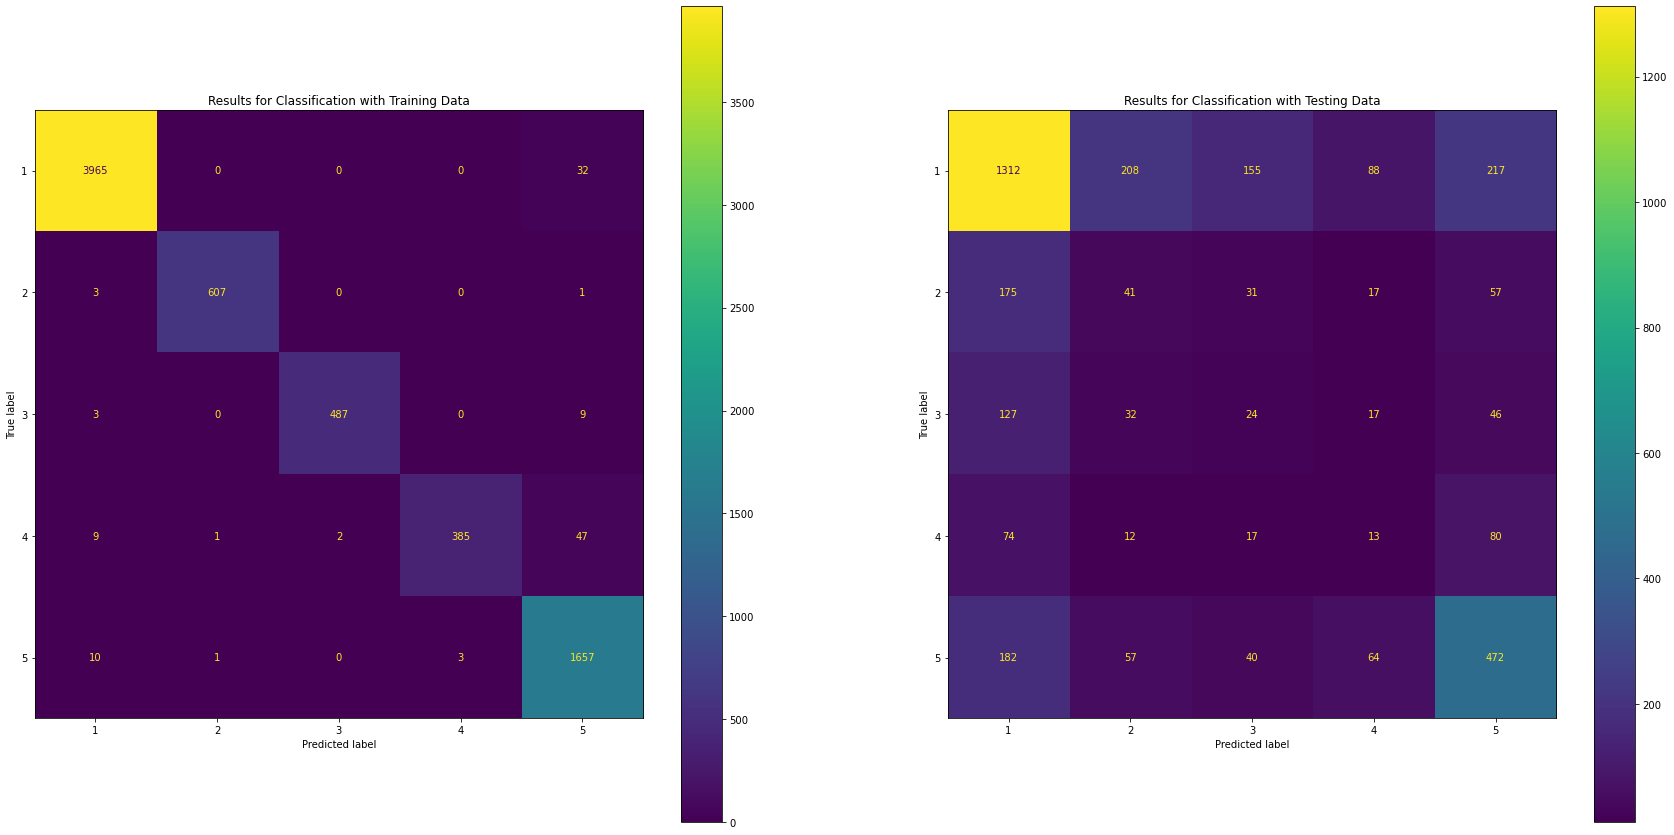

In [40]:
#4 Decision Tree Classifier
clf_name = 'Decision Tree Classifier'
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_test_predict = clf.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30,15))

print(f'{clf_name} with compressed size {C_SIZE} with training data:')
print(classification_report(y_train, y_train_predict, zero_division = 0))
print(f'R_squared with training data :{r2_score(y_train,y_train_predict)}\n')
plot_confusion_matrix(clf, X_train, y_train, ax =ax1)
ax1.set_title('Results for Classification with Training Data')

print(f'{clf_name} with compressed size {C_SIZE} with testing data:')
print(classification_report(y_test,y_test_predict, zero_division = 0))
print(f'R_squared with testing data :{r2_score(y_test,y_test_predict)}')
plot_confusion_matrix(clf, X_test, y_test, ax = ax2)
ax2.set_title('Results for Classification with Testing Data')


## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [41]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30,color=False)

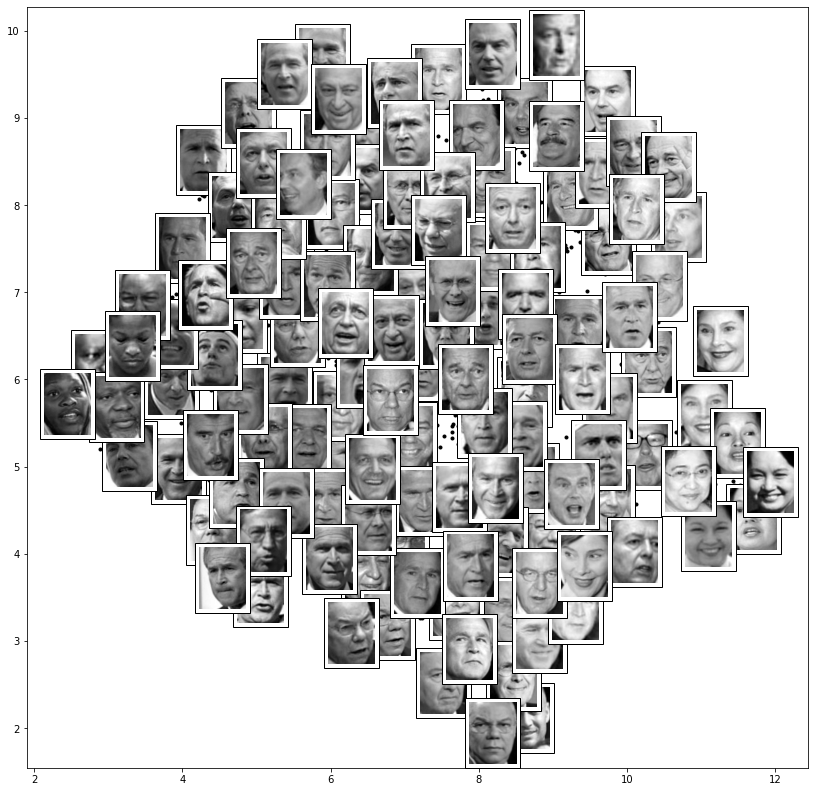

In [48]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)


fig, ax = plt.subplots(figsize=(14, 14))
model = umap.UMAP(n_neighbors=5, n_components=2)
plot_components(faces.data, model, images=faces.images, ax=ax, thumb_frac=0.05)